#  Machine Learning Application: Bull or Bear Market Prediction

## Overview
The objective of this task is to predict market regimes, classified as bull (1) and bear (0) based on multiple features across US, EU, and Japan.

The workflow begins with data loading and cleaning, then jump to **baseline model** (I use logistics regression because of y is binary) and **advanced model**(LightGBM, common tree model used for classfication) training. 

After this, I try to find the best model for the dataset by creating a **benchmarking scenario**, and the result shows that the XGB performed best, however, its accuracy score isn't higher than LGBM in the advanced model part, still not sure about the reason, maybe LGBM just fit better for the dataset. Based on this, I use LGBM as my model for **hyperparameter tuning** part, and the accuracy of the tuned model is **0.8893**, highest scorce among all models. And I used this model to generate the y_test.csv file.

In order to better understand which feature contributes more to bull market, I used **SHAP** to explain the result. It turns out that US_3M_yield has a high possibilty to increase predictions to bull market and US_stock_implied_vol has a high possibility to decrease preditions to bull market.


## Preliminaries
As usual, I start with importing some standard packages and loading data.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load data
notebook_dir = os.getcwd()
data_dir = notebook_dir + "/data"
X_train = pd.read_csv(f"{data_dir}/X_train.csv", index_col=0)
y_train = pd.read_csv(f"{data_dir}/y_train.csv", index_col=0).squeeze() #change y_train into Series
X_test = pd.read_csv(f"{data_dir}/X_test.csv", index_col=0)

## Data Cleaning and Prepraration
Usually, there are 3 parts of this stage: Handling Missing Data, Data Transformation, and String Manipulation. Since variables in the given datasets are all numerical, the only thing I need to do is handling missing data. One thing I need to point out is I use the overall mean to fill na instead of ffill or bfill methods because the statement in instruction 'the temporal structure has been anonymized', so I assumed that this is not time-series data therefore not suitable for common ffill or bfill.

In [3]:
#Check NAs in our datasets
print('Missing values in training set:', X_train.isna().sum().sum())
print('Missing values in test set:', X_test.isna().sum().sum())

Missing values in training set: 7986
Missing values in test set: 2583


In [4]:
#Fill missing values with mean()
X_train = X_train.fillna(X_train.mean()) #not ffill or bfill
X_test = X_test.fillna(X_test.mean()) #because temporal structure was anonymized

#Verify no missing values anymore
assert not X_train.isna().any().any(), "Still NaN in X_train"
assert not X_test.isna().any().any(), "Still NaN in X_test"

## Baseline Model
Because our y is binary, I use Logistics Regression as my baseline model.

In [5]:
# Import packages needed
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold #use KFold to increase the robustness of our model evaluation
from sklearn.metrics import accuracy_score #the metric mentioned in the instruction file, 'proportion of correctly predicted instances'

# Define KFold parameters
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store accuracy per fold
accuracies = []

# Cross-validation loop
for train_index, val_index in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train logistic regression
    baseline_model = LogisticRegression(max_iter=1000)
    baseline_model.fit(X_tr, y_tr)
    
    # Predict and compute accuracy
    y_val_pred = baseline_model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    accuracies.append(acc)

# Average accuracy across folds
mean_acc = np.mean(accuracies)
print(f"Average cross-validated accuracy on training data: {mean_acc:.4f}")
print(f"Accuracy per fold: {accuracies}")

# ---- Final model trained on all training data ----
final_baseline_model = LogisticRegression(max_iter=1000)
final_baseline_model.fit(X_train, y_train)

Average cross-validated accuracy on training data: 0.7407
Accuracy per fold: [0.7448347107438017, 0.75, 0.7355371900826446, 0.7365702479338843, 0.7365702479338843]


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Advanced Model
To increase the accuracy of the prediction, I use LightGBM as my Advanced model.

In [6]:
# Import package(s)
from lightgbm import LGBMClassifier, early_stopping

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, val_index in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model = LGBMClassifier(
        learning_rate=0.05,
        n_estimators=1000,          # large number, early stopping will cut it
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        force_col_wise=True
    )
    
    # Fit with early stopping
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='accuracy',
        #callbacks=[early_stopping(stopping_rounds=30, verbose=True)]
    )
    

    # Predict on validation fold
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    accuracies.append(acc)

print(f"Average CV Accuracy with Early Stopping: {np.mean(accuracies):.4f}")
print(f"Accuracy per Fold: {accuracies}")
#print("Optimal number of trees (best_iteration_):", model.best_iteration_)

[LightGBM] [Info] Number of positive: 2551, number of negative: 1321
[LightGBM] [Info] Total Bins 8413
[LightGBM] [Info] Number of data points in the train set: 3872, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.658833 -> initscore=0.658096
[LightGBM] [Info] Start training from score 0.658096
[LightGBM] [Info] Number of positive: 2528, number of negative: 1344
[LightGBM] [Info] Total Bins 8414
[LightGBM] [Info] Number of data points in the train set: 3872, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.652893 -> initscore=0.631778
[LightGBM] [Info] Start training from score 0.631778
[LightGBM] [Info] Number of positive: 2566, number of negative: 1306
[LightGBM] [Info] Total Bins 8414
[LightGBM] [Info] Number of data points in the train set: 3872, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.662707 -> initscore=0.675379
[LightGBM] [Info] Start training from score 0.675379
[LightGBM] [Info] N

## Benchmarking

/opt/miniconda3/envs/py312/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:47:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/py312/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/py312/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/py312/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:47:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" }

[LightGBM] [Info] Number of positive: 2555, number of negative: 1317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8413
[LightGBM] [Info] Number of data points in the train set: 3872, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.659866 -> initscore=0.662696
[LightGBM] [Info] Start training from score 0.662696
[LightGBM] [Info] Number of positive: 2555, number of negative: 1317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8412
[LightGBM] [Info] Number of data points in the train set: 3872, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.659866 -> initscore=0.662696
[LightGBM] [Info] Start training from score 0.662696
[LightGBM] [Info] Numb

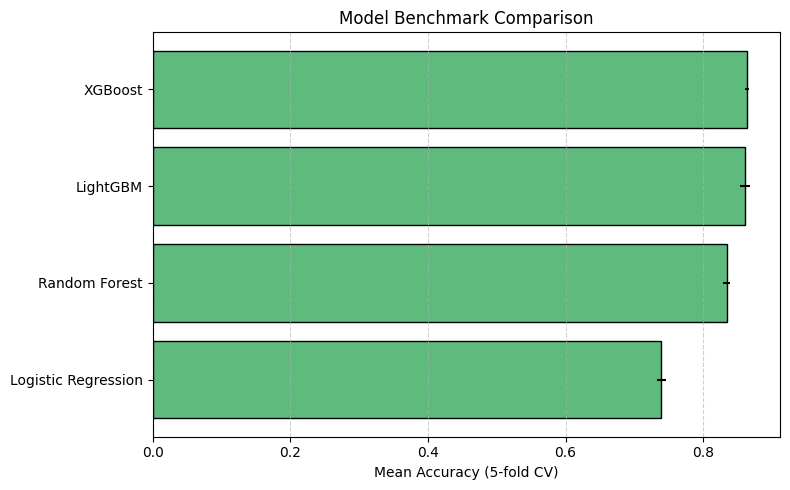

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

# Evaluate models using cross-validation (e.g., 5-fold)
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    results[name] = {
        "Mean Accuracy": np.mean(scores),
        "Std Dev": np.std(scores)
    }

# Create DataFrame
benchmark_df = pd.DataFrame(results).T.sort_values(by="Mean Accuracy", ascending=False)

# Display results table
print("Model Benchmark Results (sorted by Mean Accuracy):")
print(benchmark_df.round(4))

plt.figure(figsize=(8, 5))
plt.barh(
    benchmark_df.index,
    benchmark_df["Mean Accuracy"],
    xerr=benchmark_df["Std Dev"],
    color="#5fba7d",
    edgecolor="black"
)
plt.xlabel("Mean Accuracy (5-fold CV)")
plt.title("Model Benchmark Comparison")
plt.gca().invert_yaxis()  # Highest accuracy on top
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## Advanced model with Hyperparameter Tuning
Based on benchmarking scenario, I use XGBoost for hyperparameter tuning

In [8]:
from sklearn.model_selection import RandomizedSearchCV #didn't use GridSearchCV because it took too long to run

# Base model
xgb_base = XGBClassifier(
    eval_metric="logloss",
    random_state=42
)

# Define parameter grid for tuning
param_dist = {
    "n_estimators": [100, 500, 1000, 2000],
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
    "min_child_weight": [1, 3, 5]
}

# Randomized search (faster than GridSearch for wide ranges)
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,  # number of random combinations to try
    scoring="accuracy",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run search
xgb_search.fit(X_train, y_train)

# Best model and score
print("Best XGBoost Parameters:")
print(xgb_search.best_params_)
print(f"Best Cross-Validation Accuracy: {xgb_search.best_score_:.4f}")

# Save best model
best_xgb = xgb_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGBoost Parameters:
{'subsample': 0.6, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best Cross-Validation Accuracy: 0.8795


The tuned XBG model underperformed the untuned LGB model, which is quite surprising. Since the gap between 2 models is quite small, I guess maybe lgb fits the data better. As a result, I tried hyperparameter tuning for lgb model again.

In [9]:
# Set estimator
lgb_model = LGBMClassifier(
    objective='binary',        # assuming classification
    boosting_type='gbdt',      # standard gradient boosting
    learning_rate=0.05,        # small learning rate for stability
    n_estimators=1000,         # early stopping will trim this
    num_leaves=31,             # good starting point (2^5 - 1)
    max_depth=-1,              # let LightGBM decide
    min_child_samples=20,      # prevents overfitting small samples
    subsample=0.8,             # row sampling for regularization
    colsample_bytree=0.8,      # column sampling for regularization
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=0.1,            # L2 regularization
    random_state=42
)

#set hyperparameters
param_dist = {
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 800],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

In [10]:
# Import packages used for tuning
from sklearn.model_selection import RandomizedSearchCV

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rand_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=25,            # try 25 random combinations
    scoring='accuracy',
    cv=kf,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rand_search.fit(X_train, y_train)

print("Best Params:", rand_search.best_params_)
print(f"Best CV Accuracy: {rand_search.best_score_:.4f}") # we increased the accuracy from 0.8888 to 0.8893(though just a small increment haha)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 2551, number of negative: 1321
[LightGBM] [Info] Number of positive: 2528, number of negative: 1344
[LightGBM] [Info] Number of positive: 2566, number of negative: 1306
[LightGBM] [Info] Number of positive: 2572, number of negative: 1300
[LightGBM] [Info] Number of positive: 2551, number of negative: 1321
[LightGBM] [Info] Number of positive: 2555, number of negative: 1317
[LightGBM] [Info] Number of positive: 2528, number of negative: 1344
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

the tuned lgb model performed best among all models, I decided to use it as my final model to generate the y_test.

In [11]:
# Fit our model on all training data
best_params = rand_search.best_params_

final_model = LGBMClassifier(**best_params, random_state=42)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    eval_metric='accuracy',
    callbacks=[early_stopping(stopping_rounds=30, verbose=True)]
)

[LightGBM] [Info] Number of positive: 3193, number of negative: 1647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8413
[LightGBM] [Info] Number of data points in the train set: 4840, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.659711 -> initscore=0.662005
[LightGBM] [Info] Start training from score 0.662005


/opt/miniconda3/envs/py312/lib/python3.12/site-packages/lightgbm/callback.py:347: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,800
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,30


In [12]:
# Generate the y_test csv
y_test_pred = final_model.predict(X_test)
y_test_pred_series = pd.Series(y_test_pred, index=X_test.index, name='Target')
y_test_pred_series.to_csv("y_test.csv", index=True)

# XAI
In order to better understand which variable contributes more to 'bull' or 'bear' market, I use SHAP to visualize the result.

In [13]:
# Import shap package
import shap

# Create a TreeExplainer
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values for X_test
shap_values = explainer(X_test)

#turn shap_values into matrix for plotting
shap_values_matrix = shap_values.values
shap_values_matrix.shape

/opt/miniconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1566, 33)

In [14]:
# Import shap package
import shap

# Create a TreeExplainer
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values for X_test
shap_values = explainer(X_test)

#turn shap_values into matrix for plotting
print("Shape of result: {}".format(np.shape(shap_values)))

Shape of result: (1566, 33)


the result is already a matrix, I don't need to add delete shap_values corresponding to class 0 predictions

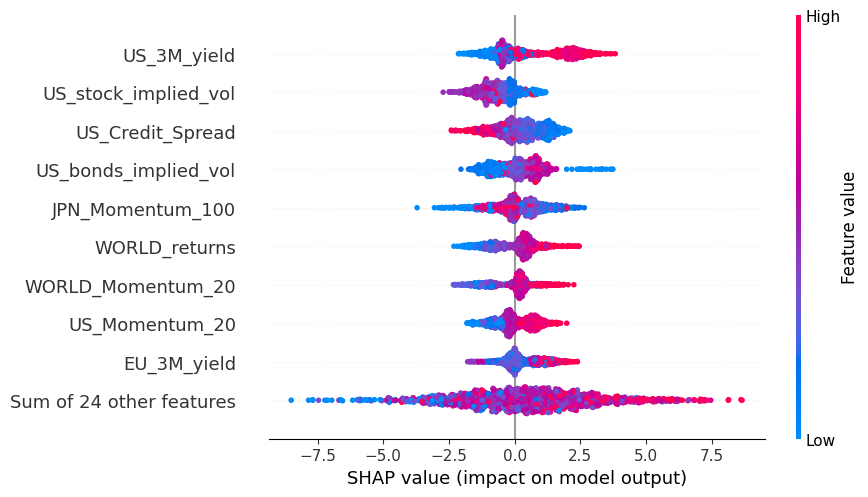

In [15]:
shap.initjs()
shap.plots.beeswarm(shap_values)

Based on the beeswarm plot, we can learn that higner values of US_3M_yield increased predicted class 1, that is, bull market. And higher US_stock_implied_vol and US_Credit_Spread decrease predicted bull market. In general, high yield and return increase bull probability, high volatility increase bear probability.

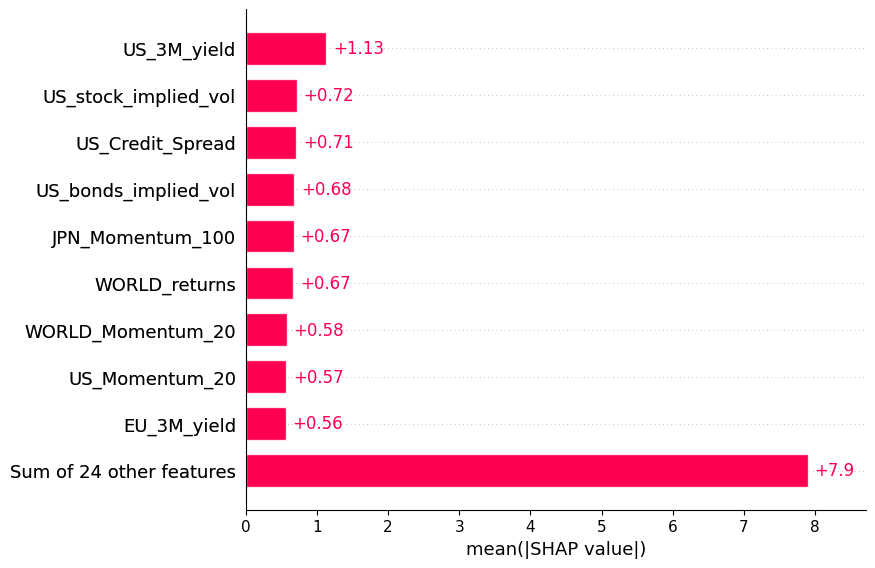

In [16]:
# SHAP-based feature importance analysis simplified
shap.initjs()
shap.plots.bar(shap_values)

It's a simplified bar plot, easy to interpret.

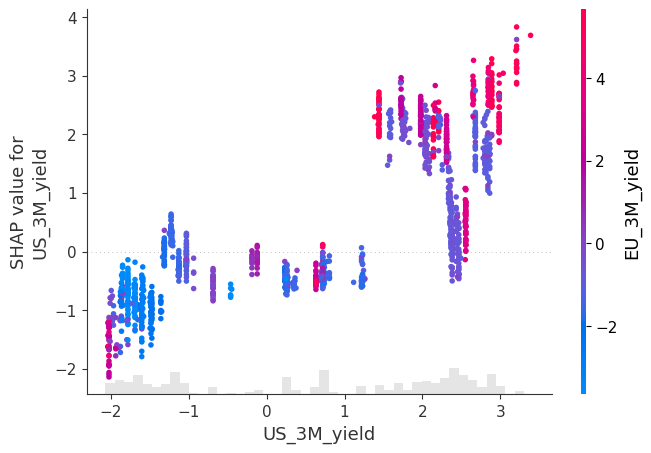

In [17]:
# SHAP-based dependence analysis 
shap.initjs()
shap.plots.scatter(shap_values[:, "US_3M_yield"], color=shap_values)

Let's have a closer look of US_3M_yield. From this scatter plot we can learn that higher US_3M_yield makes the model more likely to classify the market as a bull market and when both U.S. and European yields are high, the bullish effect is amplified; when European yields remain low, the bullish signal from U.S. yields weakens. 

## Limitations
If I can add a **Feature Engineering** part based on some researches about macroeconomics and international markets, the result may be better.